In [17]:
# Imports

import tensorflow as tf
import cv2
import os
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from glob import glob
from random import shuffle
import numpy as np

In [7]:
# Fix to tensorflow bug using CUDA  
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# source: https://github.com/tensorflow/tensorflow/issues/24828#issuecomment-464910864

/home/dhiego/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [8]:
DATADIR = "Dataset/"
NO_CLASS_LABEL='noclass'
IMG_SIZE = 150
IMG_CHANNELS=3
TRAIN_TEST_RATIO = 0.2

In [9]:
# List image addresses

labels = glob(DATADIR+'*/')
labels_str = [x.split('/')[-2] for x in labels]

# labels.insert(0, labels.pop(np.argmax([x.find(NO_CLASS_LABEL) for x in labels]))) # Push 'noclass' to the beginning

label_count = len(labels)
addrs = []

for (index, path) in enumerate(labels):
    img_addrs = glob(path+"*")
    for img_addr in img_addrs:
        addrs.append((img_addr, index))
        
shuffle(addrs)

division = int(len(addrs) * TRAIN_TEST_RATIO)
train_addrs = addrs[division:]
valid_addrs = addrs[0:division]

In [10]:
labels_str

['bird', 'noclass', 'bottle', 'lion']

In [11]:
# Read dataset into memory
x_train = np.zeros( (len(train_addrs), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.int ) # Keras input: (img_height, img_width, img_depth)
y_train_list = np.zeros( len(train_addrs), dtype=np.int )

x_valid = np.zeros( (len(valid_addrs), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.int )
y_valid_list = np.zeros( len(valid_addrs), dtype=np.int )

# Train data
for i in range(len(train_addrs)):
    addr = train_addrs[i][0]
    label = train_addrs[i][1]
    img = cv2.imread(addr)
    height, width, c = img.shape
    start_col = int(max(width/2-height/2, 0))
    end_col = int(min(start_col+height, width))
    img = img[:, start_col:end_col, ... ]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_train[i, ...] = img
    y_train_list[i] = label
    
# Validation data
for i in range(len(valid_addrs)):    
    addr = valid_addrs[i][0]
    label = valid_addrs[i][1]
    img = cv2.imread(addr)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_valid[i, ...] = img
    y_valid_list[i] = label

In [12]:
# One hot encode labels
y_train = np.zeros((y_train_list.shape[0],label_count),dtype=np.float)
y_valid = np.zeros((y_valid_list.shape[0],label_count),dtype=np.float)

y_train[np.arange(y_train.shape[0]), y_train_list] = 1.0
y_valid[np.arange(y_valid.shape[0]), y_valid_list] = 1.0

In [13]:
# Find class weights
class_weight = {x:0 for x in range(len(labels_str))}
for i in range(len(y_train)):
    class_weight[np.argmax(y_train[i])]+=1

weights0 = class_weight[0]*1.0    
for k,v in class_weight.items():
    class_weight[k]/=weights0

In [14]:
class_weight

{0: 1.0, 1: 1.7873303167420815, 2: 1.2126696832579185, 3: 1.1312217194570136}

In [10]:
# Define model

from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.losses import *

rmsprop = optimizers.RMSprop(learning_rate=0.0005, rho=0.9, momentum=0.00)

in_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS), name='input_layer', dtype=tf.float32)
x = Conv2D(64, kernel_size=5, activation='relu', name='convo1')(in_img)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=3, activation='relu', name='convo2')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=1, activation='relu', padding="same")(x)
x = Conv2D(256, kernel_size=3, activation='relu', name='convo3')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=1, activation='relu', padding="same")(x)
x = Conv2D(256, kernel_size=3, activation='relu', name='convo4')(x)

x = Conv2D(256, kernel_size=1, activation='relu', padding="same")(x)
x = Conv2D(512, kernel_size=3, activation='relu', name='convo5')(x)

x = Conv2D(512, kernel_size=3, activation='relu', name='convo6')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

output = Dense(label_count, activation='softmax', name='output_layer', dtype=tf.float32)(x)

model = Model(inputs=in_img, outputs=output)
model.compile(optimizer=rmsprop, 
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
convo1 (Conv2D)              (None, 146, 146, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
convo2 (Conv2D)              (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 35, 35, 128)       16512     
_________________________________________________________________
convo3 (Conv2D)              (None, 33, 33, 256)       295168

In [11]:
# Load weights
#model.load_weights('pre-trained.h5')
model.load_weights('trained.h5')

In [12]:
# Generators 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(
    rescale=1.0/255.0,)

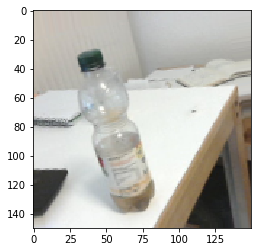

[0. 0. 1. 0.]


In [13]:
# Test generators

import matplotlib.pyplot as plt

index = 3

gen = datagen.flow(x_train, y_train, batch_size=20)
x,y = gen.next()
plt.imshow(x[index])
plt.show()
print(y[index])

In [19]:
epochs = 5
batch_size = 16

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs, 
                    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=batch_size),
                   class_weight = class_weight)

Epoch 1/5
71/70 [==============================] - 10s 144ms/step - loss: 0.4140 - accuracy: 0.9004 - val_loss: 0.5734 - val_accuracy: 0.9152
Epoch 2/5
71/70 [==============================] - 10s 144ms/step - loss: 0.4021 - accuracy: 0.9092 - val_loss: 1.2413 - val_accuracy: 0.8693
Epoch 3/5
71/70 [==============================] - 10s 143ms/step - loss: 0.6323 - accuracy: 0.8836 - val_loss: 0.6197 - val_accuracy: 0.8410
Epoch 4/5
71/70 [==============================] - 10s 143ms/step - loss: 0.3903 - accuracy: 0.9242 - val_loss: 0.9169 - val_accuracy: 0.8975
Epoch 5/5
71/70 [==============================] - 10s 143ms/step - loss: 0.4922 - accuracy: 0.8942 - val_loss: 0.5771 - val_accuracy: 0.8869


In [20]:
# Evaluate model

val_loss, val_acc = model.evaluate(x_valid, y_valid);
print(val_loss)
print(val_acc)

9/9 [==============================] - 1s 58ms/step - loss: 531.4318 - accuracy: 0.5265
531.4317626953125
0.5265017747879028


In [21]:
# Save weights hdf5 format

#model.save_weights('pre-trained.h5')
model.save_weights('trained.h5')

In [22]:
# Save model in SavedModel format (tensorflow 2.0)

export_path = 'model'

tf.saved_model.save(model, export_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [ ]:
# Load model and test signature def (Tensorflow 2.0)

import numpy as np
import matplotlib.pyplot as plt

# Load model
loaded_model = tf.keras.models.load_model('model') 

# Predict function 
predict = loaded_model.signatures["serving_default"]

In [ ]:
# Predict using loaded model

index = 12

# Define input image
img = x_valid[index:index+1]/255.0

# Predict
prediction = predict(tf.constant(img, dtype=tf.float32))

# Show results
plt.imshow(x_valid[index])  # prints the image
print(prediction['graph_output'][0])  # prints the class number
print(labels_str[np.argmax(prediction['graph_output'][0])])